## Movie Recommender with User-User collaborative filtering

We will create a movie recommender using user-user collaborative filtering logic.

The datasets available for this exercise is as follows:

 - **movies**  : This dataset has the movieId and the name and details of all the movies in the database.
 - **ratings** : This dataset has the ratings given by each userId to the movieId they have seen.
 - **tags**    : This dataset has the tags given by each userId to the movieId they have seen.
 
### The idea behind recommending movies to user based on user-user collaborative filtering is as follows :

 - **Step 1.** Create a adjusted rating for all user for their movies. This will make sure that everyone's rating is adjusted according to their overall average rating and it becomes comparable across users.
 - **Step 2.** Calculate similarity between all users based on their adjusted movie ratings. For every user's recommendation we will only consider top similar users to them (top n nearest neighbours).
 - **Step 3.** For recommending to a target yser, using the top n nearest neighbours, create weighted rating for all movies for this target user, weighting higher on more similar users. Pick the top scoring movies from this scoring as recommendations. 

In [22]:
# import key libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import gc
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.neighbors import NearestNeighbors as nn
from wordcloud import WordCloud

%matplotlib inline

sns.set(style='darkgrid')
sns.set(font_scale=1.5)

# import datasets

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
tags['tag'] = tags['tag'].str.lower()

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


In [9]:
tags.head()

,movieId,userId,tag,timestamp
0,3916,12882,sports,1147195545
1,4085,12882,eddie murphy,1147195966
2,33660,12882,boxing,1147195514
3,1197,320,must show,1145964801
4,1396,320,must show,1145964810


In [10]:
# Get basic information about the datasets

print movies.shape, ratings.shape, tags.shape
print 'Unique movies : ', movies['movieId'].nunique()
print 'Unique users in ratings data : ', ratings['userId'].nunique()
print 'Unique movies in ratings data : ', ratings['movieId'].nunique()
print 'Unique movies in tags data : ', tags['movieId'].nunique()
print 'Unique users in tags data : ', tags['userId'].nunique()
print 'Unique tags in tags data : ', tags['tag'].nunique()

(2500, 3) (264505, 4) (94875, 4)
Unique movies :  2500
Unique users in ratings data :  862
Unique movies in ratings data :  2500
Unique movies in tags data :  2495
Unique users in tags data :  862
Unique tags in tags data :  12145


### Step 1: Create adjusted user movie rating

The adjusted user rating is nothing but the average user rating for all movies ($\mu_u$) subtracted from all of their individual movie ratings ($r_{ui}$)

\begin{equation*}
R_{ui} = r_{ui} - \mu_u
\end{equation*}

This adjusted rating is now comparable across all users, as some users can naturally rate movies higher and other lower. This adjusted score basically compares the variation of user ratings from their mean rating.

In [132]:
# adjust user ratings for each movie
user_ratings = ratings.groupby(by='userId', as_index=False).agg({'rating' : 'mean'}).reset_index(drop=True)
user_ratings = user_ratings.rename(columns={'rating':'avg_rating'})

ratings_adj = ratings.merge(user_ratings,on='userId', how='inner')
ratings_adj['rating_adj'] = ratings_adj['rating'] - ratings_adj['avg_rating']

ratings_adj.head()

,userId,movieId,rating,timestamp,avg_rating,rating_adj
0,12882,1,4.0,1147195252,4.061321,-0.061321
1,12882,32,3.5,1147195307,4.061321,-0.561321
2,12882,47,5.0,1147195343,4.061321,0.938679
3,12882,50,5.0,1147185499,4.061321,0.938679
4,12882,110,4.5,1147195239,4.061321,0.438679


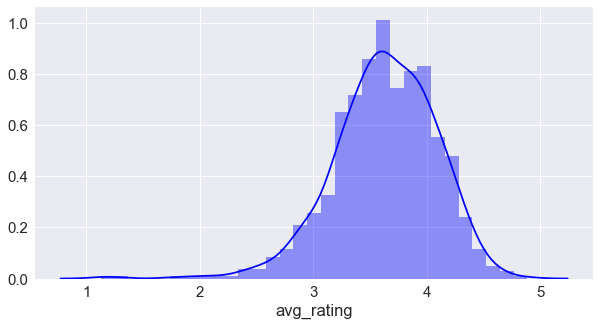

In [133]:
# Plotting Average ratings across all users
f, ax = plt.subplots(figsize = (10,5))
sns.distplot(user_ratings['avg_rating'], color='blue')

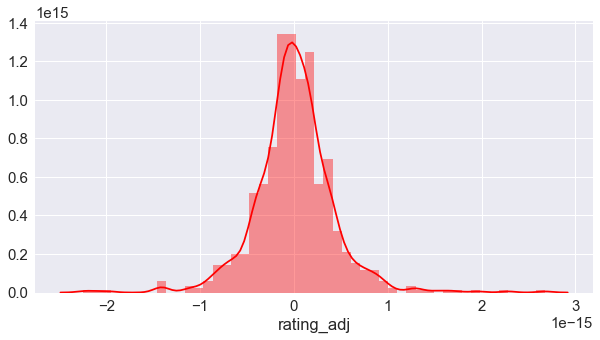

In [134]:
# Plotting Average adjusted ratings across all users
f, ax = plt.subplots(figsize = (10,5))
sns.distplot(ratings_adj.groupby(by='userId', as_index=False).\
             agg({'rating_adj' : 'mean'})['rating_adj'], color='red')

### Step 2: Create similarity score for each user with every other user

For creating this similarity score we will use the cosine similarity.


\begin{equation*}
cos(u,v) = \frac{R_u.R_v}{||R_u||.||R_v||} = \frac{\sum_{i} R_{ui}.R_{vi}}{\sqrt{\sum_{i}R_{ui}^2}.\sqrt{\sum_{i}R_{ui}^2}} 
\end{equation*}

where,

1. $cos(u,v)$ is the cosine similarity score for user U and user V
2. $R_u$ and $R_v$ are the rating vector of user U and User V for all the movies
3. summation over all i movies

In [137]:
# create a transformed dataset for user and movieid level to get the adjusted ratings
ratings_adj_tf = ratings_adj[['userId', 'movieId', 'rating_adj']].\
                    pivot(index='userId', columns='movieId', values='rating_adj').fillna(0)
print ratings_adj_tf.shape

# similarity matrix - cosine distance
dist = pd.DataFrame(data=cs(ratings_adj_tf), index=ratings_adj_tf.index, columns=ratings_adj_tf.index)
print dist.shape

dist.head()

(862, 2500)
(862, 862)


userId,316,320,359,370,910,975,1015,1387,1447,1588,...,137118,137209,137227,137446,137559,137609,137805,138072,138176,138200
userId,,,,,,,,,,,,,,,,,,,,,
316,1.000000,0.060063,0.072075,0.043266,0.039305,0.045616,0.035341,0.038068,-0.012485,0.050183,...,0.052632,0.104864,0.011358,0.029674,0.092552,0.017876,0.051371,0.077377,0.026924,-0.022727
320,0.060063,1.000000,0.063054,0.027315,0.006811,0.075620,0.011910,0.042509,0.000000,0.067389,...,0.115325,0.065130,0.071996,0.097554,0.064769,-0.006251,0.077256,0.098845,0.038752,0.056639
359,0.072075,0.063054,1.000000,0.135836,0.076131,0.036757,0.046418,0.066544,0.042877,0.109726,...,0.120191,0.020672,0.032166,0.039599,0.108502,0.026371,0.075492,0.102698,0.099307,0.003147
370,0.043266,0.027315,0.135836,1.000000,0.108404,0.071655,0.070893,-0.003139,0.052235,0.090241,...,0.091218,0.049594,0.004344,0.040692,0.110434,0.019767,-0.001364,0.052187,0.050997,0.009950
910,0.039305,0.006811,0.076131,0.108404,1.000000,0.021814,0.027339,-0.032211,-0.006301,-0.007491,...,0.039464,-0.017620,0.020058,-0.004581,0.040866,-0.001438,-0.026082,0.073272,-0.012058,0.007610


### Step 3: Create a recommendation for a given target user

The steps for creating a recommendation for a target user will be in form of a function. The steps followed in the function will be as follows - 

1. get the top 30 most similar users for the target user. We are choosing 30 here but it could be more or less.
2. using the ratings of these top users, create a score for each movie. This score is basically a weighted rating of each movie. the weight here is the similarity score of the user. so more similar users ratings get a higher weightage.
 

\begin{equation*}
S_{u,i} =  \mu_u + \frac{\sum_{v} cos(u,v).(r_{vi} - \mu_v)}{\sum_{v} cos(u,v)}
\end{equation*}

where,
 - $S_{u,i}$ is the score for the movie i
 - $cos(u,v)$ is the cosine similarity between target user U and close neighbour user V
 - $r_{vi}$ is the rating of the neighbour user V for movie i
 - $\mu_v$ is the average rating for user V for all of their rated movies
 - $\mu_u$ is the average rating for target user U for all of their rated movies

3. Once we have the rating for all the movies for target user U, remove the movies they have already rated and also the movies which don't have more than 2 users rating them
4. sort the movies based on rating and recommend the top n movies for the user

In [140]:
def top_movie_reco(user, n=10, nbr=30):
    dist_temp = dist[dist.index == user].sort_values(by = user, axis =1, ascending=False)
    dist_temp = dist_temp.iloc[:,0:nbr+1].transpose().reset_index()
    dist_temp = dist_temp.rename(columns={user:'user_similarity'})
    dist_temp['target_user'] = user
    dist_temp = dist_temp[dist_temp['userId'] != user]
    dist_temp['target_avg_rating'] = user_ratings[user_ratings['userId'] == user]['avg_rating'].iloc[0]
    
    # get the movie ratings for all the userid in the top neighbors
    dist_temp = dist_temp.merge(ratings_adj[['userId', 'movieId', 'avg_rating', 'rating_adj']],\
                                on='userId', how='inner')
    dist_temp = dist_temp.sort_values(by=['movieId', 'userId']).reset_index(drop=True)
    
    # remove movies that don't have more than 2 users
    movie_users = dist_temp.groupby(by='movieId', as_index=False).agg({'userId':'nunique'}).reset_index(drop=True).\
                    rename(columns={'userId':'user_count'})
    dist_temp = dist_temp.merge(movie_users, on='movieId', how='inner')
    dist_temp = dist_temp[dist_temp['user_count'] > 2]
    dist_temp['score'] = dist_temp['rating_adj'] * dist_temp['user_similarity']
    
    # get the score for each movie
    movie_score = dist_temp.groupby(by='movieId', as_index=False).agg({'score':'sum', 'user_similarity':'sum'})
    movie_score['target_avg_rating'] = user_ratings[user_ratings['userId'] == user]['avg_rating'].iloc[0]
    movie_score['final_score'] = movie_score['target_avg_rating'] + \
                                    (movie_score['score']/movie_score['user_similarity'])
    movie_score = movie_score.sort_values(by='final_score', ascending=False).reset_index(drop=True)
    movie_score = movie_score.merge(movies, on='movieId', how='inner')
    
    # remove the movies which the user has already rated
    movie_already_rated = list(ratings[ratings['userId'] == user][['movieId']].iloc[:,0])
    movie_score = movie_score[~movie_score['movieId'].isin(movie_already_rated)]
    
    # return the top relevant movies
    del dist_temp
    del movie_users
    del movie_already_rated
    return movie_score[['movieId', 'title', 'genres', 'final_score']]

# check for one of the user
targ_user = 320
n = 15
top_mvs = top_movie_reco(targ_user, n)
top_mvs.head(n)

,movieId,title,genres,final_score
0,1230,Annie Hall (1977),Comedy|Romance,4.952629
1,7502,Band of Brothers (2001),Action|Drama|War,4.952597
2,5971,My Neighbor Totoro (Tonari no Totoro) (1988),Animation|Children|Drama|Fantasy,4.727727
3,3198,Papillon (1973),Crime|Drama,4.727508
4,6104,Monty Python Live at the Hollywood Bowl (1982),Comedy,4.713084
5,7371,Dogville (2003),Drama|Mystery|Thriller,4.706103
6,2467,"Name of the Rose, The (Name der Rose, Der) (1986)",Crime|Drama|Mystery|Thriller,4.705292
7,306,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,4.700283
11,4848,Mulholland Drive (2001),Crime|Drama|Film-Noir|Mystery|Thriller,4.623240
12,1209,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,4.618548
